In [52]:
import os

dataset_path = "/Users/chikazalianty/Desktop/chika"

os.listdir(dataset_path)

['.DS_Store', 'test', 'train', 'validation']

In [53]:
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

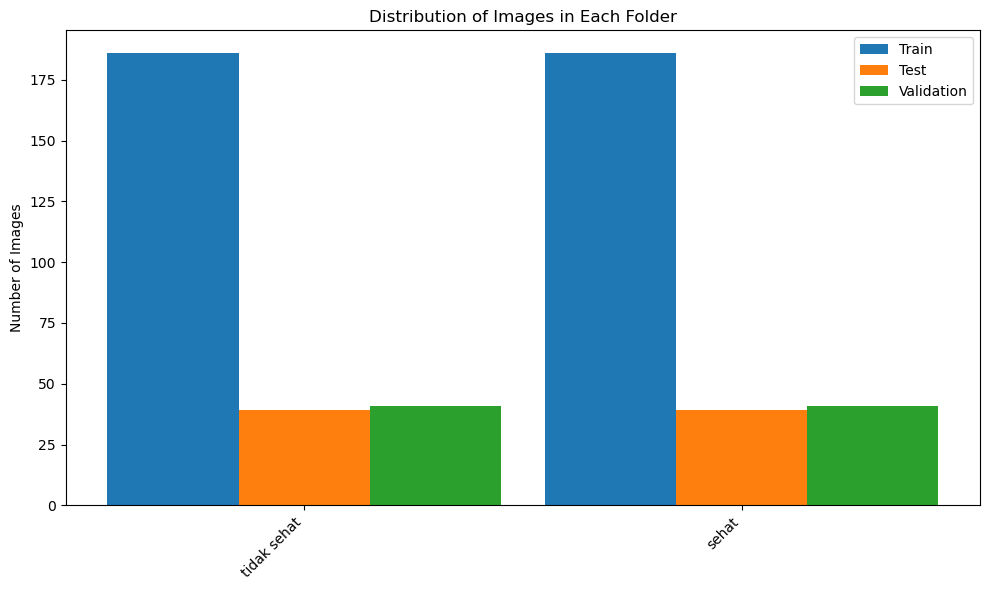

In [54]:
import os
import matplotlib.pyplot as plt
import numpy as np

folders = ['train', 'test', 'validation']

subfolder_lengths = {folder: {} for folder in folders}

for folder in folders:
    subfolders_path = os.path.join(dataset_path, folder)
    subfolders = [subfolder for subfolder in os.listdir(subfolders_path) if os.path.isdir(os.path.join(subfolders_path, subfolder))]
    
    for subfolder in subfolders:
        subfolder_length = len(os.listdir(os.path.join(subfolders_path, subfolder)))
        subfolder_lengths[folder][subfolder] = subfolder_length

subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())

x = np.arange(len(subfolder_names))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')

ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [59]:
batch_size = 15
image_shape = (240, 240)

train_datagen = ImageDataGenerator(

    rescale=1/255,
    shear_range=0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.5, 1.5],  # Adjust brightness between 50% and 150%
    rotation_range=40,  # Rotate images by up to 40 degrees
    zoom_range = 0.2

)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 371 images belonging to 2 classes.


In [60]:
validation_datagen = ImageDataGenerator(
    rescale=1/255,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 82 images belonging to 2 classes.


In [61]:
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False

)

Found 77 images belonging to 2 classes.


In [62]:
#VGG16

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(10)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model and add the VGG16 base
model = Sequential()
model.add(base_model)

# Add custom fully connected layers on top of the VGG16 base
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights_vgg16.h5", 
                                      monitor='val_accuracy', 
                                      save_best_only=True, 
                                      mode='max', verbose=1)

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_27 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               65664     
                                                                 
 dense_29 (Dense)            (None, 2)                 258       
                                                                 
Total params: 27626178 (105.39 MB)
Trainable params: 1

In [63]:
# Assuming you have defined train_generator and validation_generator
batch_size = 15
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 50

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

# Find the epoch with the best accuracy on the validation (test) set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print(f"Best epoch is ==> epoch {best_epoch}")

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 2.3891 - accuracy: 0.5169
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to best_epoch_weights_vgg16.h5
24/24 [==============================] - 92s 4s/step - loss: 2.3891 - accuracy: 0.5169 - val_loss: 0.8655 - val_accuracy: 0.5600
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.6854
Epoch 2: val_accuracy improved from 0.56000 to 0.74667, saving model to best_epoch_weights_vgg16.h5
24/24 [==============================] - 111s 5s/step - loss: 0.8800 - accuracy: 0.6854 - val_loss: 0.5959 - val_accuracy: 0.7467
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.6798
Epoch 3: val_accuracy improved from 0.74667 to 0.85333, saving model to best_epoch_weights_vgg16.h5
24/24 [==============================] - 143s 6s/step - loss: 0.7740 - accuracy: 0.6798 - val_loss: 0.3802 - val_accuracy: 0.8533
Epoch 4/50
24/24 [==============

24/24 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8820
Epoch 29: val_accuracy did not improve from 0.98667
24/24 [==============================] - 79s 3s/step - loss: 0.2733 - accuracy: 0.8820 - val_loss: 0.1524 - val_accuracy: 0.9467
Epoch 30/50
24/24 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9326
Epoch 30: val_accuracy did not improve from 0.98667
24/24 [==============================] - 78s 3s/step - loss: 0.1641 - accuracy: 0.9326 - val_loss: 0.1488 - val_accuracy: 0.9467
Epoch 31/50
24/24 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9494
Epoch 31: val_accuracy did not improve from 0.98667
24/24 [==============================] - 78s 3s/step - loss: 0.1296 - accuracy: 0.9494 - val_loss: 0.1260 - val_accuracy: 0.9600
Epoch 32/50
24/24 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9298
Epoch 32: val_accuracy did not improve from 0.98667
24/24 [==============================

In [64]:
# Load the weights of the best model
best_model = model

# Compile the best_model
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

best_model.load_weights('best_epoch_weights_vgg16.h5')

# Save the best model in .tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model to disk
with open('model_vgg16_2.tflite', 'wb') as f:
    f.write(tflite_model)

print("Training done and best model saved as .tflite")

INFO:tensorflow:Assets written to: /var/folders/rj/5jtwzsfj38s98_p1rgslvlh40000gn/T/tmp4csgyqmx/assets


INFO:tensorflow:Assets written to: /var/folders/rj/5jtwzsfj38s98_p1rgslvlh40000gn/T/tmp4csgyqmx/assets
2024-01-18 00:58:50.905714: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-18 00:58:50.905737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-18 00:58:50.906020: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/rj/5jtwzsfj38s98_p1rgslvlh40000gn/T/tmp4csgyqmx
2024-01-18 00:58:50.909359: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-18 00:58:50.909377: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/rj/5jtwzsfj38s98_p1rgslvlh40000gn/T/tmp4csgyqmx
2024-01-18 00:58:50.918909: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-18 00:58:51.057646: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

Training done and best model saved as .tflite


In [65]:
evaluation = best_model.evaluate(test_generator,verbose=0)
print(f"Test Accuracy = {round(evaluation[1],2)}")
print(f"Test Loss = {round(evaluation[0],3)}")

Test Accuracy = 0.96
Test Loss = 0.099


In [67]:
evaluation2 = best_model.evaluate(validation_generator,verbose=0)
print(f"Validation Accuracy = {round(evaluation2[1],2)}")
print(f"Validation Loss = {round(evaluation2[0],3)}")

Validation Accuracy = 0.99
Validation Loss = 0.056


In [68]:
# Evaluate the model on the validation set
val_loss, val_acc = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc}')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

6/6 [==============================] - 10s 2s/step - loss: 0.0564 - accuracy: 0.9878
Validation Accuracy: 0.9878048896789551
6/6 [==============================] - 11s 2s/step - loss: 0.0990 - accuracy: 0.9610
Test Accuracy: 0.9610389471054077


6/6 [==============================] - 10s 2s/step
Precision: 0.9613
Recall: 0.9610
F1-Score: 0.9610
Accuracy: 0.9610


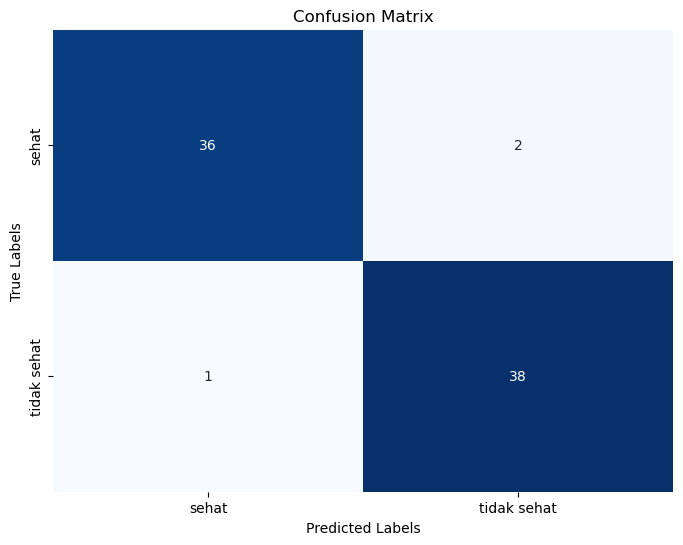

In [75]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict labels on the validation set
test_steps = len(test_generator)
test_pred_probs = best_model.predict(test_generator, steps=test_steps, verbose=1)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Get true labels directly from the generator
test_true_labels = test_generator.classes

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1_score, _ = classification_report(test_true_labels, test_pred_labels, digits=4, output_dict=True)['weighted avg'].values()
accuracy = accuracy_score(test_true_labels, test_pred_labels)

# Display the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(accuracy))

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
